# Oxygen Time Series – Exploratory Data Analysis (EDA)

This notebook performs a comprehensive exploratory data analysis (EDA) of the **oxygen saturation time series** dataset used in the Cefalo Lead Data Scientist assignment.

The goals are to:

- Understand the structure of the dataset (columns, time span, sampling frequency).
- Explore data quality (missingness patterns, outliers, strange values).
- Characterise behaviour per system / equipment / subunit (logical sensors).
- Inspect temporal patterns (hour-of-day, month-by-month, trends and volatility).
- Derive insights that will inform **forecasting** and **anomaly detection** design.


In [1]:
# Standard imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from pathlib import Path

# Display options
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

%matplotlib inline


## 1. Load the dataset

> **Note:** Update `DATA_PATH` below if your `oxygen.csv` is in a different folder.


In [2]:
DATA_DIR = os.path.abspath(os.path.join(os.getcwd(), "../" , "data"))
DATA_RAW_DIR = Path(os.path.join(DATA_DIR, "raw"))
# Path to the dataset (adjust this if needed)
DATA_PATH = Path(os.path.join(DATA_RAW_DIR, "oxygen.csv"))

In [3]:
# Path to the dataset
DATA_PATH = Path(DATA_PATH)  # change to e.g. Path("data/oxygen.csv") if needed

assert DATA_PATH.exists(), f"File not found at {DATA_PATH.resolve()}"

df = pd.read_csv(DATA_PATH)
df.head()

,time,Oxygen[%sat],EquipmentUnit,SubUnit,System,Unit
0,2025-04-01 17:43:00,NaN,EquipmentUnit_05,NaN,System_01,Unit_01
1,2025-04-01 17:44:00,NaN,EquipmentUnit_05,NaN,System_01,Unit_01
2,2025-04-01 17:45:00,NaN,EquipmentUnit_05,NaN,System_01,Unit_01
3,2025-04-01 17:46:00,NaN,EquipmentUnit_05,NaN,System_01,Unit_01
4,2025-04-01 17:47:00,NaN,EquipmentUnit_05,NaN,System_01,Unit_01


## 2. Basic structure and data types

We start by checking:

- Shape (rows, columns)
- Column names and data types
- A quick preview of the first few rows


In [4]:
print("Shape (rows, columns):", df.shape)
print("\nColumns and dtypes:")
print(df.dtypes)

print("\nBasic .info():")
df.info()


Shape (rows, columns): (7128273, 6)

Columns and dtypes:
time              object
Oxygen[%sat]     float64
EquipmentUnit     object
SubUnit           object
System            object
Unit              object
dtype: object

Basic .info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7128273 entries, 0 to 7128272
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   time           object 
 1   Oxygen[%sat]   float64
 2   EquipmentUnit  object 
 3   SubUnit        object 
 4   System         object 
 5   Unit           object 
dtypes: float64(1), object(5)
memory usage: 326.3+ MB


## 3. Time parsing and basic time coverage

We convert the `time` column to a proper `datetime` dtype, sort by time, and inspect:

- Min / max timestamps
- Overall time span
- Gaps between timestamps (to check sampling frequency)


In [5]:
df['time'] = pd.to_datetime(df['time'], errors="coerce")
df = df.sort_values('time').reset_index(drop=True)

min_time = df['time'].min()
max_time = df['time'].max()
print("Time range:")
print("  Min:", min_time)
print("  Max:", max_time)
print("  Span:", max_time - min_time)

time_unique = df['time'].drop_duplicates().sort_values()
time_diffs = time_unique.diff().dropna()

print("\nTime gap summary between unique timestamps:")
print(time_diffs.describe())

long_gaps = time_diffs[time_diffs > pd.Timedelta(minutes=1)]
print("\nNumber of gaps > 1 minute:", long_gaps.shape[0])
if not long_gaps.empty:
    print("Top 10 longest gaps:")
    print(long_gaps.sort_values(ascending=False).head(10))


Time range:
  Min: 2025-04-01 17:43:00
  Max: 2025-11-14 09:31:00
  Span: 226 days 15:48:00

Time gap summary between unique timestamps:
count                       324733
mean     0 days 00:01:00.305789679
std      0 days 00:02:31.720069009
min                0 days 00:00:59
25%                0 days 00:01:00
50%                0 days 00:01:00
75%                0 days 00:01:00
max                1 days 00:01:00
Name: time, dtype: object

Number of gaps > 1 minute: 54
Top 10 longest gaps:
2083250   1 days 00:01:00
4913068   0 days 00:34:00
5207238   0 days 00:28:00
4904466   0 days 00:14:00
5633014   0 days 00:14:00
4190364   0 days 00:13:00
4906674   0 days 00:11:00
4909250   0 days 00:11:00
5960718   0 days 00:08:00
4190269   0 days 00:07:00
Name: time, dtype: timedelta64[ns]


## 4. Missingness and basic oxygen statistics

We examine:

- Missing values per column
- Overall distribution of `Oxygen[%sat]` (non-null values only)


Missing values per column:
time               66664
Oxygen[%sat]     5497413
EquipmentUnit          0
SubUnit          3280828
System                 0
Unit                   0
dtype: int64

Missing values % per column:
time              0.935205
Oxygen[%sat]     77.121247
EquipmentUnit     0.000000
SubUnit          46.025566
System            0.000000
Unit              0.000000
dtype: float64

Non-null Oxygen[%sat] count: 1630860

Basic stats for Oxygen[%sat] (non-null only):
count    1.630860e+06
mean     8.774095e+01
std      5.954170e+00
min     -2.170147e-02
25%      8.459909e+01
50%      8.881170e+01
75%      9.098113e+01
max      1.413579e+02
Name: Oxygen[%sat], dtype: float64


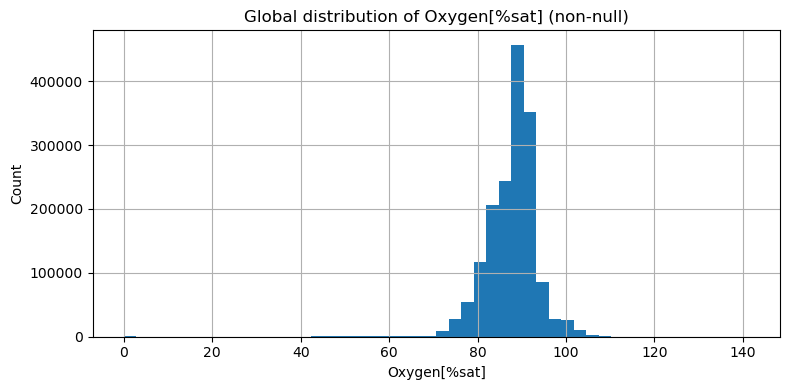

In [6]:
print("Missing values per column:")
print(df.isna().sum())

print("\nMissing values % per column:")
print(df.isna().mean() * 100)

oxygen = df['Oxygen[%sat]']
non_null_oxygen = oxygen.dropna()

print("\nNon-null Oxygen[%sat] count:", non_null_oxygen.shape[0])
print("\nBasic stats for Oxygen[%sat] (non-null only):")
print(non_null_oxygen.describe())

plt.figure(figsize=(8, 4))
non_null_oxygen.hist(bins=50)
plt.title("Global distribution of Oxygen[%sat] (non-null)")
plt.xlabel("Oxygen[%sat]")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


## 5. Coverage by system, equipment, and subunit

We next look at where the oxygen readings actually exist:

- Non-null counts per `System`
- Non-null counts per `(System, EquipmentUnit)`
- Non-null counts per `(EquipmentUnit, SubUnit)` (logical sensors)


In [7]:
non_null_mask = df['Oxygen[%sat]'].notna()

system_counts = df.groupby('System')['Oxygen[%sat]'].agg(['count', lambda x: x.notna().sum()])
system_counts.columns = ['total_rows', 'non_null_oxygen']
system_counts['non_null_rate'] = system_counts['non_null_oxygen'] / system_counts['total_rows']
system_counts

,total_rows,non_null_oxygen,non_null_rate
System,,,
System_01,0,0,NaN
System_02,0,0,NaN
System_03,0,0,NaN
System_04,0,0,NaN
System_05,0,0,NaN
System_06,0,0,NaN
System_07,0,0,NaN
System_08,0,0,NaN
System_09,0,0,NaN


In [8]:
system_equipment_counts = (
    df.groupby(['System', 'EquipmentUnit'])['Oxygen[%sat]']
      .agg(['count', lambda x: x.notna().sum()])
      .reset_index()
)
system_equipment_counts.columns = ['System', 'EquipmentUnit', 'total_rows', 'non_null_oxygen']
system_equipment_counts['non_null_rate'] = system_equipment_counts['non_null_oxygen'] / system_equipment_counts['total_rows']
system_equipment_counts.sort_values(['System', 'EquipmentUnit']).head(20)


,System,EquipmentUnit,total_rows,non_null_oxygen,non_null_rate
0,System_01,EquipmentUnit_03,0,0,NaN
1,System_01,EquipmentUnit_05,0,0,NaN
2,System_01,EquipmentUnit_06,0,0,NaN
3,System_01,EquipmentUnit_07,0,0,NaN
4,System_01,EquipmentUnit_08,0,0,NaN
5,System_01,EquipmentUnit_09,0,0,NaN
6,System_02,EquipmentUnit_01,0,0,NaN
7,System_02,EquipmentUnit_02,0,0,NaN
8,System_03,EquipmentUnit_09,0,0,NaN
9,System_03,EquipmentUnit_10,0,0,NaN


In [9]:
sensor_counts = (
    df.groupby(['EquipmentUnit', 'SubUnit'])['Oxygen[%sat]']
      .agg(['count', lambda x: x.notna().sum()])
      .reset_index()
)
sensor_counts.columns = ['EquipmentUnit', 'SubUnit', 'total_rows', 'non_null_oxygen']
sensor_counts['non_null_rate'] = sensor_counts['non_null_oxygen'] / sensor_counts['total_rows']
sensor_counts.sort_values(['non_null_oxygen'], ascending=False).head(20)


,EquipmentUnit,SubUnit,total_rows,non_null_oxygen,non_null_rate
23,EquipmentUnit_10,SubUnit_08,326172,326172,1.0
22,EquipmentUnit_10,SubUnit_07,326172,326172,1.0
0,EquipmentUnit_01,SubUnit_22,0,0,NaN
16,EquipmentUnit_06,SubUnit_06,0,0,NaN
29,EquipmentUnit_16,SubUnit_12,0,0,NaN
28,EquipmentUnit_15,SubUnit_11,0,0,NaN
27,EquipmentUnit_14,SubUnit_10,0,0,NaN
26,EquipmentUnit_13,SubUnit_14,0,0,NaN
25,EquipmentUnit_13,SubUnit_09,0,0,NaN
24,EquipmentUnit_13,SubUnit_01,0,0,NaN


## 6. Focus on active sensors

We filter to non-null oxygen rows, build a sensor identifier, and pivot to a **wide** per-minute table.


In [10]:
df_non_null = df[df['Oxygen[%sat]'].notna()].copy()

systems_with_data = df_non_null['System'].unique()
print("Systems with non-null oxygen:", systems_with_data)

# Optionally filter to a specific system with data, e.g.:
# df_non_null = df_non_null[df_non_null['System'] == 'System_10']

df_non_null['sensor_id'] = df_non_null['EquipmentUnit'].astype(str) + " | " + df_non_null['SubUnit'].astype(str)

print("\nTop sensors by non-null count:")
print(df_non_null['sensor_id'].value_counts().head(10))

sensor_pivot = (
    df_non_null
    .pivot_table(index='time', columns='sensor_id', values='Oxygen[%sat]')
    .sort_index()
)
sensor_pivot.head()


Systems with non-null oxygen: ['System_10']

Top sensors by non-null count:
sensor_id
EquipmentUnit_06 | nan           326172
EquipmentUnit_05 | nan           326172
EquipmentUnit_10 | SubUnit_08    326172
EquipmentUnit_10 | SubUnit_07    326172
EquipmentUnit_11 | nan           326172
Name: count, dtype: int64


sensor_id,EquipmentUnit_05 | nan,EquipmentUnit_06 | nan,EquipmentUnit_10 | SubUnit_07,EquipmentUnit_10 | SubUnit_08,EquipmentUnit_11 | nan
time,,,,,
2025-04-01 17:43:00,91.639549,91.935204,90.521339,91.377579,89.844864
2025-04-01 17:44:00,91.443474,92.234970,91.519485,88.592575,90.270912
2025-04-01 17:45:00,91.784111,92.268089,90.132881,90.332207,90.002838
2025-04-01 17:46:00,92.180275,92.423836,92.266747,88.941963,90.053604
2025-04-01 17:47:00,92.131180,92.521950,87.957130,88.769760,90.132881


## 7. Descriptive statistics per sensor


In [11]:
sensor_stats = sensor_pivot.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T
sensor_stats


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
sensor_id,,,,,,,,,,,,
EquipmentUnit_05 | nan,322439.0,90.084757,5.703647,32.895313,59.402629,83.234684,89.183414,90.421883,91.835308,96.545814,102.350961,140.553131
EquipmentUnit_06 | nan,322889.0,91.070571,3.896608,65.774078,80.040381,83.741554,89.591873,90.810799,92.264870,99.378452,102.271579,141.357941
EquipmentUnit_10 | SubUnit_07,322439.0,83.155032,4.859527,31.886669,72.424454,74.631992,80.027695,83.420364,86.291855,90.472740,95.123369,106.797638
EquipmentUnit_10 | SubUnit_08,322439.0,86.478189,6.681307,-0.021701,75.276078,78.631493,83.239349,85.995789,89.821709,96.549721,100.372682,115.114044
EquipmentUnit_11 | nan,322433.0,87.997426,4.742168,21.809864,74.035565,81.423424,86.508942,88.397263,90.183617,93.554688,97.323952,139.308350


## 8. Extreme values and potential outliers


In [12]:
def count_extremes(arr, condition):
    return np.sum(condition(arr))

extreme_summary = []

for col in sensor_pivot.columns:
    series = sensor_pivot[col].dropna()
    extreme_summary.append({
        'sensor_id': col,
        'count': series.shape[0],
        'min': series.min(),
        'max': series.max(),
        'n_lt_40': count_extremes(series, lambda x: x < 40),
        'n_lt_60': count_extremes(series, lambda x: x < 60),
        'n_gt_110': count_extremes(series, lambda x: x > 110),
        'n_gt_120': count_extremes(series, lambda x: x > 120),
        'n_le_0': count_extremes(series, lambda x: x <= 0),
    })

extreme_df = pd.DataFrame(extreme_summary)
extreme_df


,sensor_id,count,min,max,n_lt_40,n_lt_60,n_gt_110,n_gt_120,n_le_0
0,EquipmentUnit_05 | nan,322439,32.895313,140.553131,89,3362,265,36,0
1,EquipmentUnit_06 | nan,322889,65.774078,141.357941,0,0,228,28,0
2,EquipmentUnit_10 | SubUnit_07,322439,31.886669,106.797638,6,23,0,0,0
3,EquipmentUnit_10 | SubUnit_08,322439,-0.021701,115.114044,765,1048,45,0,429
4,EquipmentUnit_11 | nan,322433,21.809864,139.308350,326,1285,156,32,0


## 9. Temporal patterns – hour of day


In [13]:
df_non_null['hour'] = df_non_null['time'].dt.hour

hourly_stats = df_non_null.groupby('hour')['Oxygen[%sat]'].agg(['mean', 'std', 'min', 'max', 'count'])
hourly_stats


,mean,std,min,max,count
hour,,,,,
0.0,87.753589,6.052506,-0.007234,114.075119,67425
1.0,87.719948,6.077893,-0.015885,105.767990,67500
2.0,87.645157,6.038593,-0.007234,105.554039,67485
3.0,87.486113,6.248394,-0.007234,107.784660,67470
4.0,87.376183,6.262884,-0.007234,110.778214,67420
5.0,87.473784,6.407153,-0.007234,107.645645,67405
6.0,87.490814,6.339667,-0.021701,115.114044,67415
7.0,87.525181,6.145156,-0.021701,112.750313,67434
8.0,87.692293,5.774460,28.829912,125.470772,67390


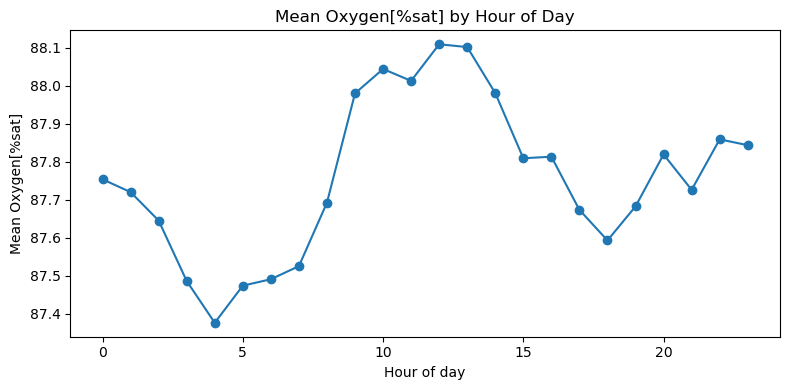

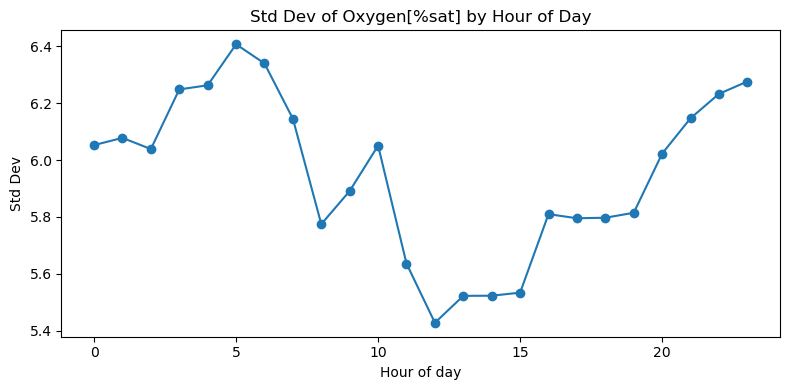

In [14]:
plt.figure(figsize=(8, 4))
hourly_stats['mean'].plot(marker='o')
plt.title("Mean Oxygen[%sat] by Hour of Day")
plt.xlabel("Hour of day")
plt.ylabel("Mean Oxygen[%sat]")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
hourly_stats['std'].plot(marker='o')
plt.title("Std Dev of Oxygen[%sat] by Hour of Day")
plt.xlabel("Hour of day")
plt.ylabel("Std Dev")
plt.tight_layout()
plt.show()


## 10. Temporal patterns – month-by-month behaviour


In [15]:
df_non_null['month'] = df_non_null['time'].dt.to_period('M')

monthly_sensor_stats = (
    df_non_null
    .groupby(['month', 'sensor_id'])['Oxygen[%sat]']
    .agg(['count', 'mean', 'std', 'min', 'max'])
    .reset_index()
)

monthly_sensor_stats.head(20)


,month,sensor_id,count,mean,std,min,max
0,2025-04,EquipmentUnit_05 | nan,42136,90.476343,1.476958,85.277840,101.450775
1,2025-04,EquipmentUnit_06 | nan,42136,91.043730,1.467668,85.866455,105.218430
2,2025-04,EquipmentUnit_10 | SubUnit_07,42136,88.623819,3.280869,35.011673,106.797638
3,2025-04,EquipmentUnit_10 | SubUnit_08,42136,91.503200,4.051905,26.886786,108.254349
4,2025-04,EquipmentUnit_11 | nan,42136,89.143959,1.634557,78.913750,101.098923
5,2025-05,EquipmentUnit_05 | nan,44638,90.479006,1.661111,83.794075,101.725945
6,2025-05,EquipmentUnit_06 | nan,44638,91.096419,1.627272,84.943321,102.743546
7,2025-05,EquipmentUnit_10 | SubUnit_07,44638,84.681326,3.596443,46.827263,102.437561
8,2025-05,EquipmentUnit_10 | SubUnit_08,44638,88.226824,5.808972,31.828865,115.114044
9,2025-05,EquipmentUnit_11 | nan,44638,89.239721,1.996321,80.678474,105.635574


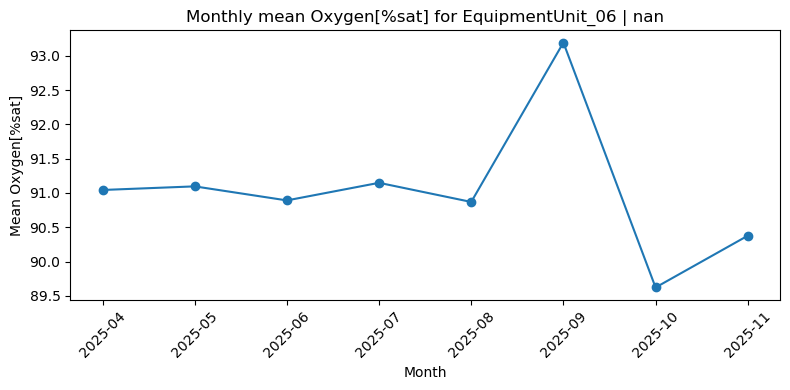

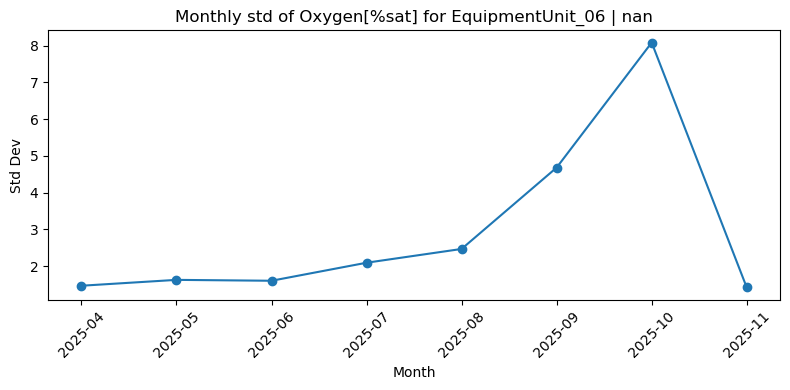

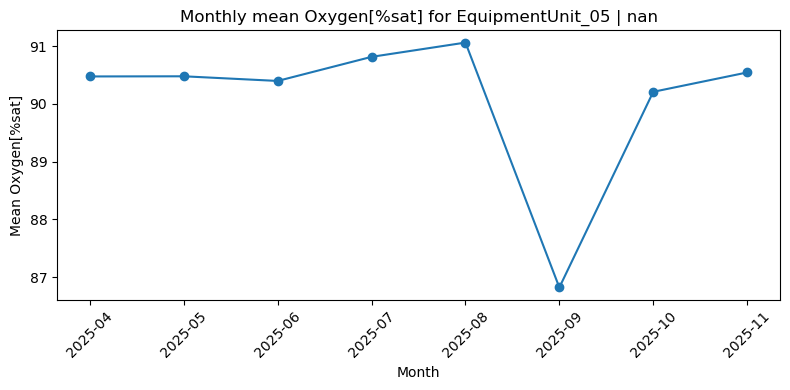

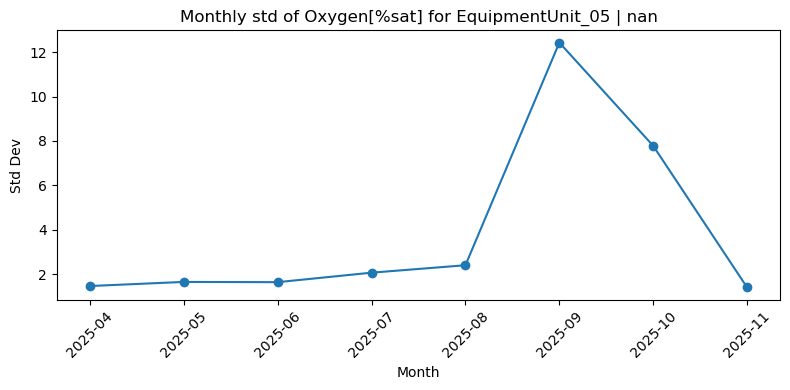

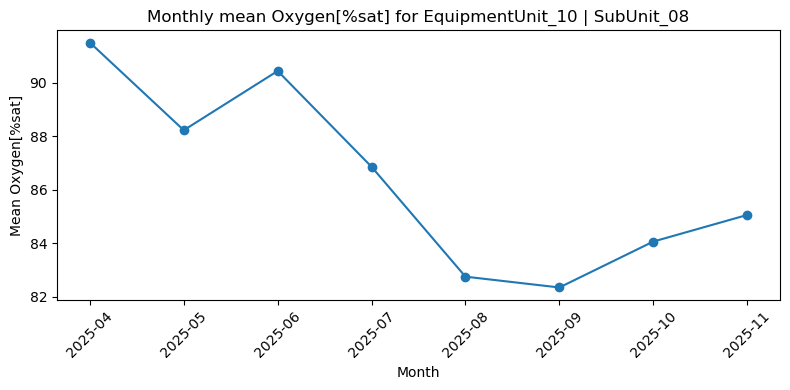

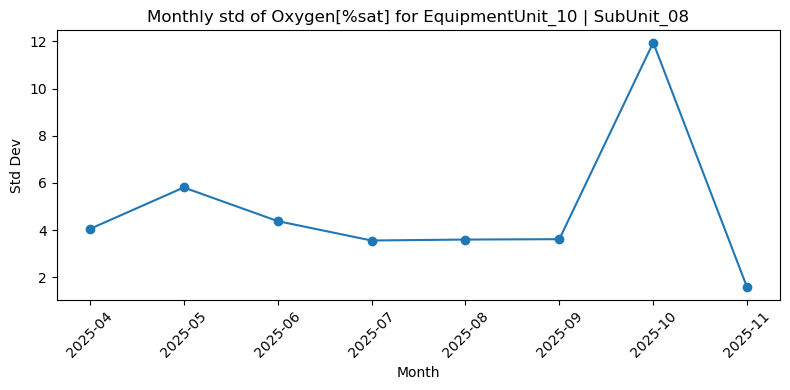

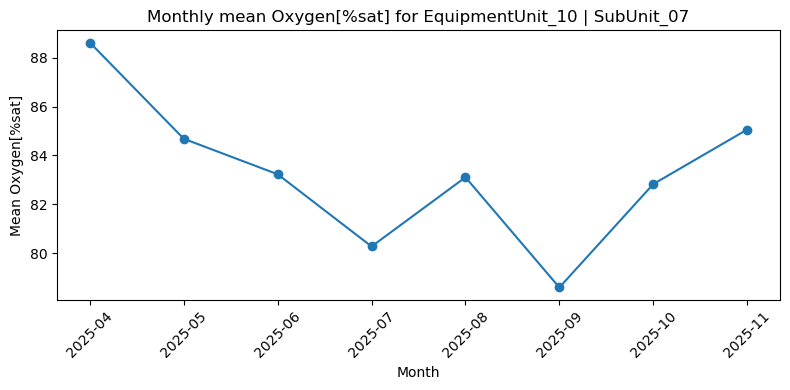

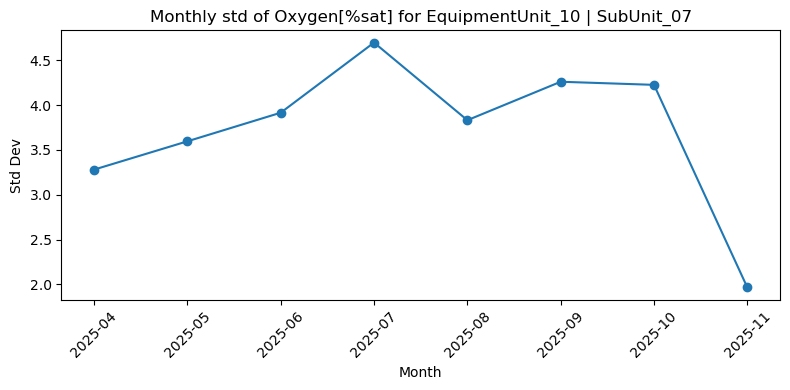

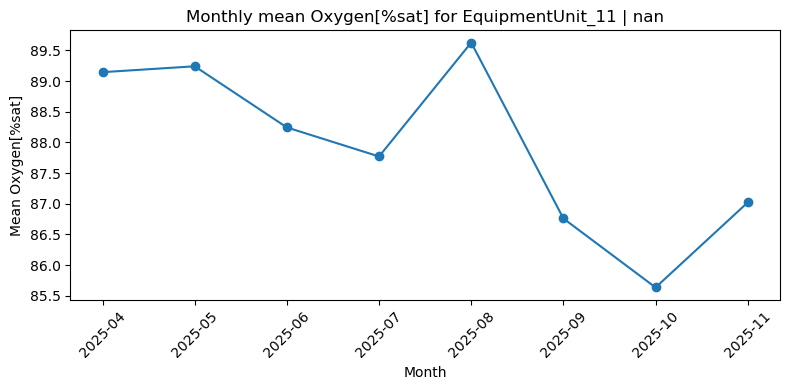

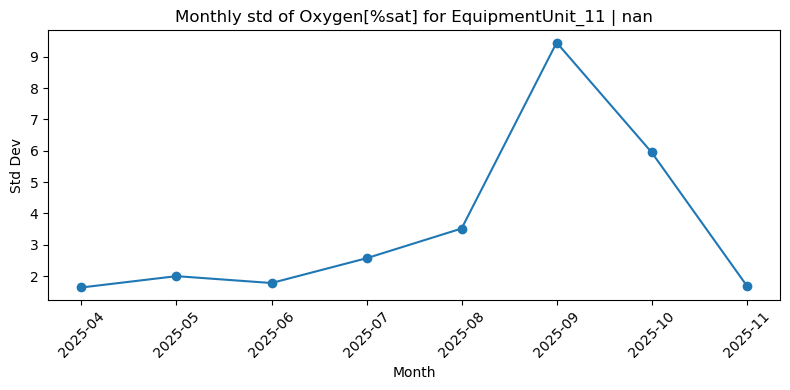

In [16]:
top_sensors = df_non_null['sensor_id'].value_counts().head(5).index.tolist()

for sensor in top_sensors:
    tmp = monthly_sensor_stats[monthly_sensor_stats['sensor_id'] == sensor].copy()
    tmp = tmp.sort_values('month')
    tmp['month_str'] = tmp['month'].astype(str)

    plt.figure(figsize=(8, 4))
    plt.plot(tmp['month_str'], tmp['mean'], marker='o')
    plt.title(f"Monthly mean Oxygen[%sat] for {sensor}")
    plt.xlabel("Month")
    plt.ylabel("Mean Oxygen[%sat]")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(tmp['month_str'], tmp['std'], marker='o')
    plt.title(f"Monthly std of Oxygen[%sat] for {sensor}")
    plt.xlabel("Month")
    plt.ylabel("Std Dev")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## 11. Sample time series plots


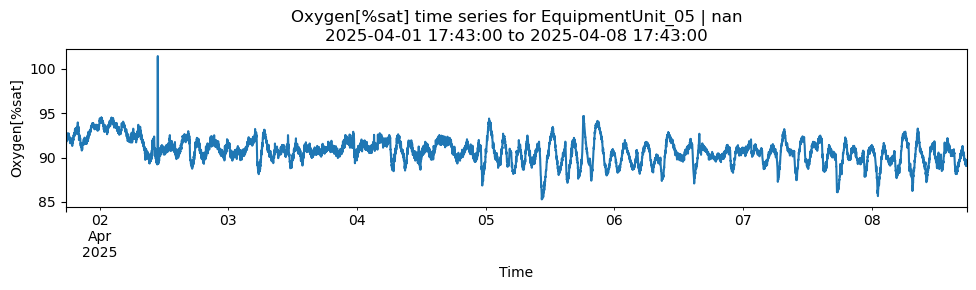

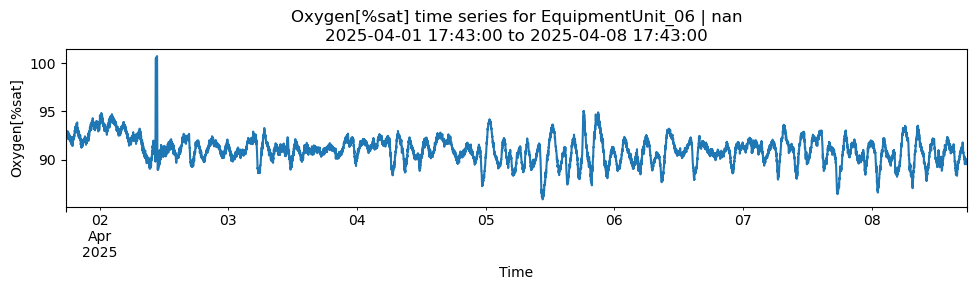

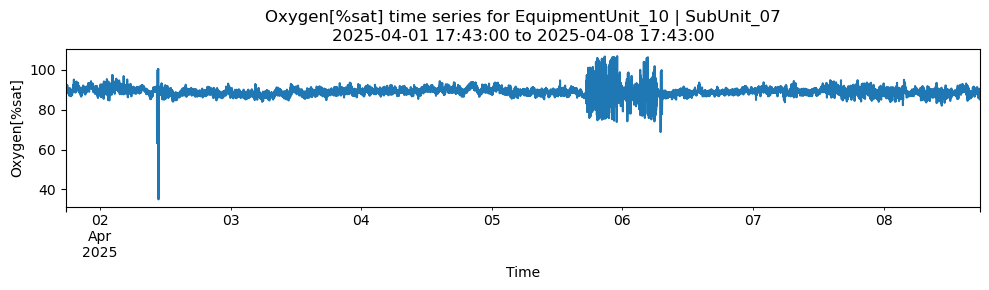

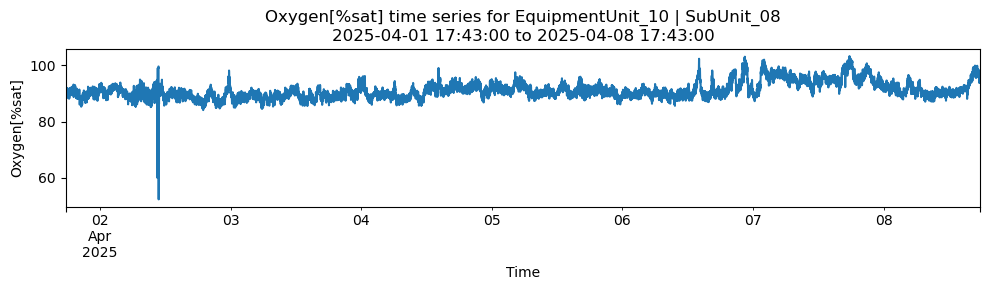

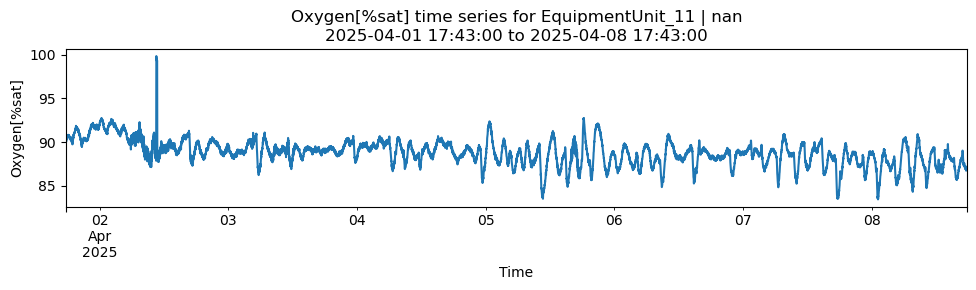

In [17]:
start_date = sensor_pivot.index.min()
end_date = start_date + pd.Timedelta(days=7)

sample = sensor_pivot.loc[start_date:end_date]

for sensor in sample.columns:
    plt.figure(figsize=(10, 3))
    sample[sensor].plot()
    plt.title(f"Oxygen[%sat] time series for {sensor}\n{start_date} to {end_date}")
    plt.xlabel("Time")
    plt.ylabel("Oxygen[%sat]")
    plt.tight_layout()
    plt.show()


## 12. Correlations between sensors


In [18]:
active_sensors = sensor_pivot.columns.tolist()
sensor_pivot_full = sensor_pivot[active_sensors].dropna()

corr = sensor_pivot_full.corr()
corr


sensor_id,EquipmentUnit_05 | nan,EquipmentUnit_06 | nan,EquipmentUnit_10 | SubUnit_07,EquipmentUnit_10 | SubUnit_08,EquipmentUnit_11 | nan
sensor_id,,,,,
EquipmentUnit_05 | nan,1.000000,0.233125,0.159083,0.072325,0.701102
EquipmentUnit_06 | nan,0.233125,1.000000,0.158818,0.011800,0.209791
EquipmentUnit_10 | SubUnit_07,0.159083,0.158818,1.000000,0.391308,0.172822
EquipmentUnit_10 | SubUnit_08,0.072325,0.011800,0.391308,1.000000,0.080679
EquipmentUnit_11 | nan,0.701102,0.209791,0.172822,0.080679,1.000000


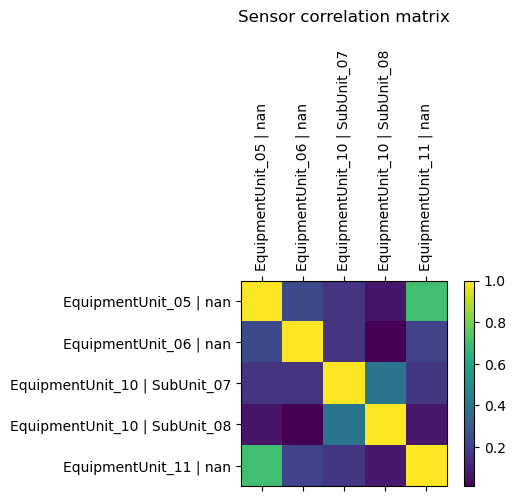

In [19]:
fig, ax = plt.subplots(figsize=(6, 5))
cax = ax.matshow(corr.values)
fig.colorbar(cax)
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.index)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.index)
plt.title("Sensor correlation matrix", pad=20)
plt.tight_layout()
plt.show()


## 13. Summary of key EDA insights

Use this section to document the main findings from the EDA and how they inform the modelling and anomaly detection design.
